In [1]:
import torch
import torchvision
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.3.0+cu121
torchvision version: 0.18.0+cu121


In [17]:
# Continue with regular imports
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms

from torchinfo import summary

import data_setup, engine
from utils import set_seeds, plot_loss_curves, save_model

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
# Setup directory paths to train and test images
train_dir = 'data/organized/train'
test_dir = 'data/organized/test'

# EffNetB2

In [7]:
# 1. Setup pretrained EffNetB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# 2. Get EffNetB2 transforms
effnetb2_transforms = effnetb2_weights.transforms()

# 3. Setup pretrained model
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights) # could also use weights="DEFAULT"

# 4. Freeze the base layers in the model (this will freeze all layers to begin with)
for param in effnetb2.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to C:\Users\macie/.cache\torch\hub\checkpoints\efficientnet_b2_rwightman-c35c1473.pth
100.0%


In [8]:
# Check out EffNetB2 classifier head
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [9]:
# 5. Update the classifier head
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True), # keep dropout layer same
    nn.Linear(in_features=1408, # keep in_features same 
              out_features=3)) # change out_features to suit our number of classes

In [10]:
def create_effnetb2_model(num_classes:int=3, 
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model. 
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # 1, 2, 3. Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )
    
    return model, transforms

In [11]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)

In [12]:
# # Print EffNetB2 model summary (uncomment for full output) 
summary(effnetb2, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [13]:
# Setup DataLoaders
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

In [15]:
# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Set seeds for reproducibility and train the model
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9323 | train_acc: 0.5634 | test_loss: 0.8548 | test_acc: 0.6164
Epoch: 2 | train_loss: 0.8843 | train_acc: 0.5925 | test_loss: 0.8443 | test_acc: 0.6202
Epoch: 3 | train_loss: 0.8729 | train_acc: 0.5999 | test_loss: 0.8331 | test_acc: 0.6269
Epoch: 4 | train_loss: 0.8747 | train_acc: 0.6011 | test_loss: 0.8407 | test_acc: 0.6240
Epoch: 5 | train_loss: 0.8749 | train_acc: 0.6015 | test_loss: 0.8234 | test_acc: 0.6377
Epoch: 6 | train_loss: 0.8671 | train_acc: 0.6047 | test_loss: 0.8276 | test_acc: 0.6366
Epoch: 7 | train_loss: 0.8691 | train_acc: 0.6019 | test_loss: 0.8255 | test_acc: 0.6403
Epoch: 8 | train_loss: 0.8677 | train_acc: 0.6069 | test_loss: 0.8236 | test_acc: 0.6243
Epoch: 9 | train_loss: 0.8683 | train_acc: 0.6066 | test_loss: 0.8225 | test_acc: 0.6312
Epoch: 10 | train_loss: 0.8699 | train_acc: 0.6037 | test_loss: 0.8192 | test_acc: 0.6352


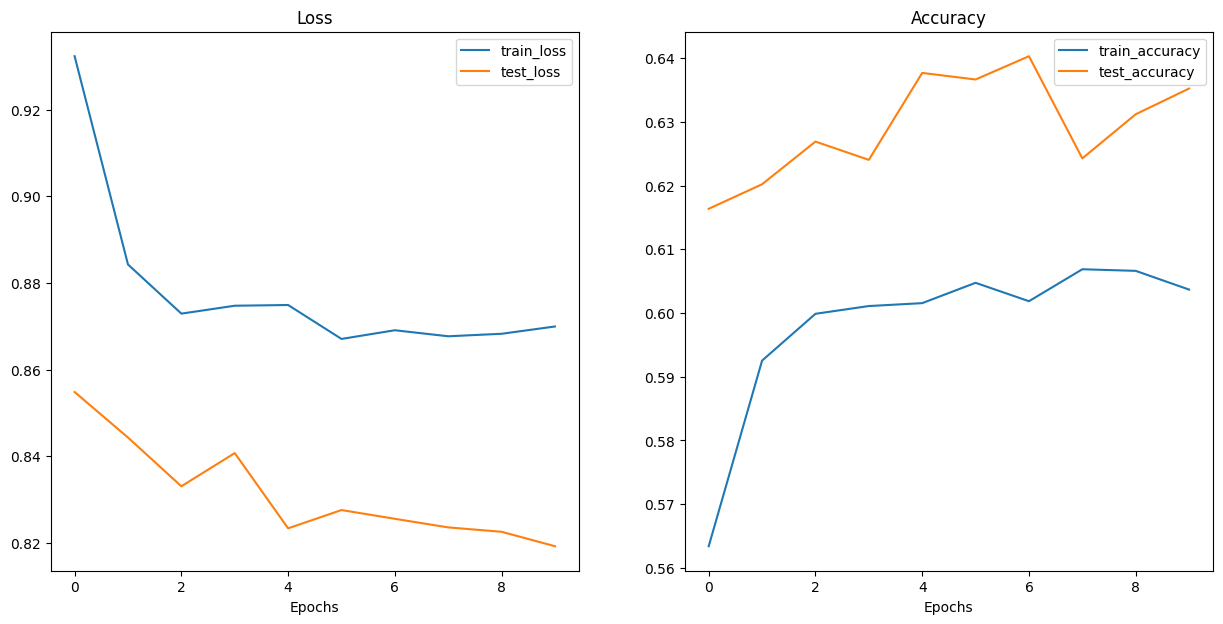

In [16]:
plot_loss_curves(effnetb2_results)

In [19]:
# Save the model
save_model(model=effnetb2,
            target_dir="models",
            model_name="pretrained_effnetb2_feature_extractor.pth")

[INFO] Saving model to: models\pretrained_effnetb2_feature_extractor.pth


In [21]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_model_size = Path("models/pretrained_effnetb2_feature_extractor.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetB2 feature extractor model size: 29 MB


In [22]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [23]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.8192190256018144,
 'test_acc': 0.6352246543778802,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

# ViT

In [24]:
# Check out ViT heads layer
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [25]:
def create_vit_model(num_classes:int=3, 
                     seed:int=42):
    """Creates a ViT-B/16 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of target classes. Defaults to 3.
        seed (int, optional): random seed value for output layer. Defaults to 42.

    Returns:
        model (torch.nn.Module): ViT-B/16 feature extractor model. 
        transforms (torchvision.transforms): ViT-B/16 image transforms.
    """
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)) # update to reflect target number of classes
    
    return model, transforms

In [26]:
# Create ViT model and transforms
vit, vit_transforms = create_vit_model(num_classes=3,
                                       seed=42)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to C:\Users\macie/.cache\torch\hub\checkpoints\vit_b_16-c867db91.pth
100.0%


In [27]:
# # Print ViT feature extractor model summary (uncomment for full output)
summary(vit, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

c:\projects\mushroom_image_classification\venv\Lib\site-packages\torch\nn\modules\activation.py:1221: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  return torch._native_multi_head_attention(


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [28]:
# Setup ViT DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

In [29]:
# Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train ViT model with seeds set for reproducibility
set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8491 | train_acc: 0.6095 | test_loss: 0.7880 | test_acc: 0.6508
Epoch: 2 | train_loss: 0.7624 | train_acc: 0.6611 | test_loss: 0.7618 | test_acc: 0.6624
Epoch: 3 | train_loss: 0.7354 | train_acc: 0.6789 | test_loss: 0.7525 | test_acc: 0.6644
Epoch: 4 | train_loss: 0.7229 | train_acc: 0.6834 | test_loss: 0.7545 | test_acc: 0.6672
Epoch: 5 | train_loss: 0.7161 | train_acc: 0.6900 | test_loss: 0.7478 | test_acc: 0.6752
Epoch: 6 | train_loss: 0.7076 | train_acc: 0.6939 | test_loss: 0.7448 | test_acc: 0.6764
Epoch: 7 | train_loss: 0.7043 | train_acc: 0.6966 | test_loss: 0.7489 | test_acc: 0.6768
Epoch: 8 | train_loss: 0.7011 | train_acc: 0.6964 | test_loss: 0.7460 | test_acc: 0.6847
Epoch: 9 | train_loss: 0.6978 | train_acc: 0.6975 | test_loss: 0.7760 | test_acc: 0.6661
Epoch: 10 | train_loss: 0.6980 | train_acc: 0.7006 | test_loss: 0.7451 | test_acc: 0.6801


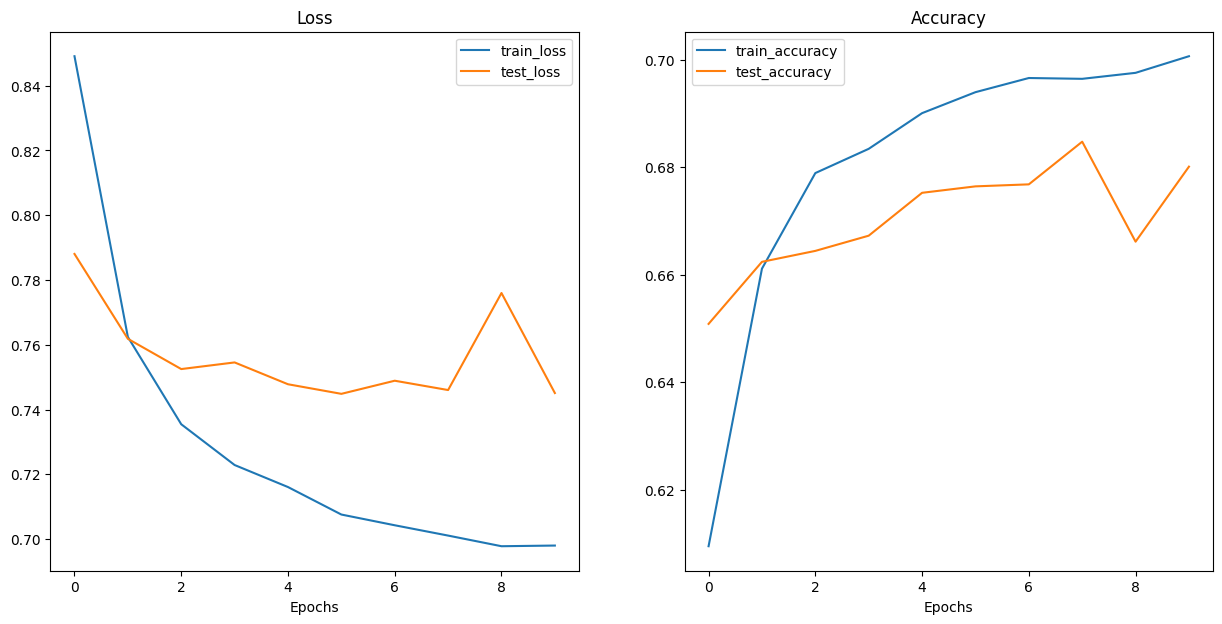

In [30]:
plot_loss_curves(vit_results)

In [31]:
save_model(model=vit,
            target_dir="models",
            model_name="pretrained_vit_feature_extractor.pth")

[INFO] Saving model to: models\pretrained_vit_feature_extractor.pth


In [32]:
# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/pretrained_vit_feature_extractor.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


In [33]:
# Count number of parameters in ViT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [34]:
# Create ViT statistics dictionary
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}

vit_stats

{'test_loss': 0.7450875550411739,
 'test_acc': 0.6800835253456221,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

In [35]:
# Get all test data paths
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: data/organized/test


[WindowsPath('data/organized/test/edible/Agaricus augustus_10.jpg'),
 WindowsPath('data/organized/test/edible/Agaricus augustus_107.jpg'),
 WindowsPath('data/organized/test/edible/Agaricus augustus_109.jpg'),
 WindowsPath('data/organized/test/edible/Agaricus augustus_112.jpg'),
 WindowsPath('data/organized/test/edible/Agaricus augustus_116.jpg')]

In [36]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer 
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths: List[pathlib.Path], 
                   model: torch.nn.Module,
                   transform: torchvision.transforms, 
                   class_names: List[str], 
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
    
    # 2. Create an empty list to store prediction dictionaires
    pred_list = []
    
    # 3. Loop through target paths
    for path in tqdm(paths):
        
        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # 5. Get the sample path and ground truth class name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name
        
        # 6. Start the prediction timer
        start_time = timer()
        
        # 7. Open image path
        img = Image.open(path)
        
        # 8. Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device) 
        
        # 9. Prepare model for inference by sending it to target device and turning on eval() mode
        model.to(device)
        model.eval()
        
        # 10. Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image) # perform inference on target sample 
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

            # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on) 
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class
            
            # 12. End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # 13. Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)
    
    # 15. Return list of prediction dictionaries
    return pred_list

In [37]:
# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu") # make predictions on CPU 

  0%|          | 0/4916 [00:00<?, ?it/s]

In [38]:
# Inspect the first 2 prediction dictionaries
effnetb2_test_pred_dicts[:2]

[{'image_path': WindowsPath('data/organized/test/edible/Agaricus augustus_10.jpg'),
  'class_name': 'edible',
  'pred_prob': 0.7329,
  'pred_class': 'edible',
  'time_for_pred': 0.4213,
  'correct': True},
 {'image_path': WindowsPath('data/organized/test/edible/Agaricus augustus_107.jpg'),
  'class_name': 'edible',
  'pred_prob': 0.4437,
  'pred_class': 'non-edible',
  'time_for_pred': 0.2717,
  'correct': False}]

In [39]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data\organized\test\edible\Agaricus augustus_1...,edible,0.7329,edible,0.4213,True
1,data\organized\test\edible\Agaricus augustus_1...,edible,0.4437,non-edible,0.2717,False
2,data\organized\test\edible\Agaricus augustus_1...,edible,0.6265,edible,0.2774,True
3,data\organized\test\edible\Agaricus augustus_1...,edible,0.5561,edible,0.2679,True
4,data\organized\test\edible\Agaricus augustus_1...,edible,0.4955,non-edible,0.2679,False


In [40]:
# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

correct
True     3122
False    1794
Name: count, dtype: int64

In [43]:
from sklearn.metrics import classification_report

y_true = effnetb2_test_pred_df['class_name']
y_pred = effnetb2_test_pred_df['pred_class']
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      edible       0.66      0.74      0.70      2289
  non-edible       0.61      0.61      0.61      1511
       toxic       0.60      0.46      0.52      1116

    accuracy                           0.64      4916
   macro avg       0.62      0.60      0.61      4916
weighted avg       0.63      0.64      0.63      4916



In [44]:
# Find the average time per prediction 
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")

EffNetB2 average time per prediction: 0.3006 seconds


In [45]:
# Add EffNetB2 average prediction time to stats dictionary 
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.8192190256018144,
 'test_acc': 0.6352246543778802,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'time_per_pred_cpu': 0.3006}

In [46]:
# Make list of prediction dictionaries with ViT feature extractor model on test images
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu")

  0%|          | 0/4916 [00:00<?, ?it/s]

In [47]:
# Check the first couple of ViT predictions on the test dataset
vit_test_pred_dicts[:2]

[{'image_path': WindowsPath('data/organized/test/edible/Agaricus augustus_10.jpg'),
  'class_name': 'edible',
  'pred_prob': 0.7604,
  'pred_class': 'edible',
  'time_for_pred': 0.5854,
  'correct': True},
 {'image_path': WindowsPath('data/organized/test/edible/Agaricus augustus_107.jpg'),
  'class_name': 'edible',
  'pred_prob': 0.7266,
  'pred_class': 'edible',
  'time_for_pred': 0.4168,
  'correct': True}]

In [48]:
# Turn vit_test_pred_dicts into a DataFrame
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data\organized\test\edible\Agaricus augustus_1...,edible,0.7604,edible,0.5854,True
1,data\organized\test\edible\Agaricus augustus_1...,edible,0.7266,edible,0.4168,True
2,data\organized\test\edible\Agaricus augustus_1...,edible,0.6604,non-edible,0.4870,False
3,data\organized\test\edible\Agaricus augustus_1...,edible,0.5365,toxic,0.4108,False
4,data\organized\test\edible\Agaricus augustus_1...,edible,0.5070,edible,0.4116,True


In [49]:
# Count the number of correct predictions
vit_test_pred_df.correct.value_counts()

correct
True     3343
False    1573
Name: count, dtype: int64

In [50]:
y_true = vit_test_pred_df['class_name']
y_pred = vit_test_pred_df['pred_class']
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      edible       0.72      0.75      0.73      2289
  non-edible       0.66      0.66      0.66      1511
       toxic       0.63      0.57      0.60      1116

    accuracy                           0.68      4916
   macro avg       0.67      0.66      0.66      4916
weighted avg       0.68      0.68      0.68      4916



In [51]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred} seconds")

ViT average time per prediction: 0.3639 seconds


In [52]:
# Add average prediction time for ViT model on CPU
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.7450875550411739,
 'test_acc': 0.6800835253456221,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'time_per_pred_cpu': 0.3639}

In [53]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.819219,63.52,7705221,29,0.3006,EffNetB2
1,0.745088,68.01,85800963,327,0.3639,ViT


In [54]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]), # divide ViT statistics by EffNetB2 statistics
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.90951,1.070686,11.135432,11.275862,1.210579


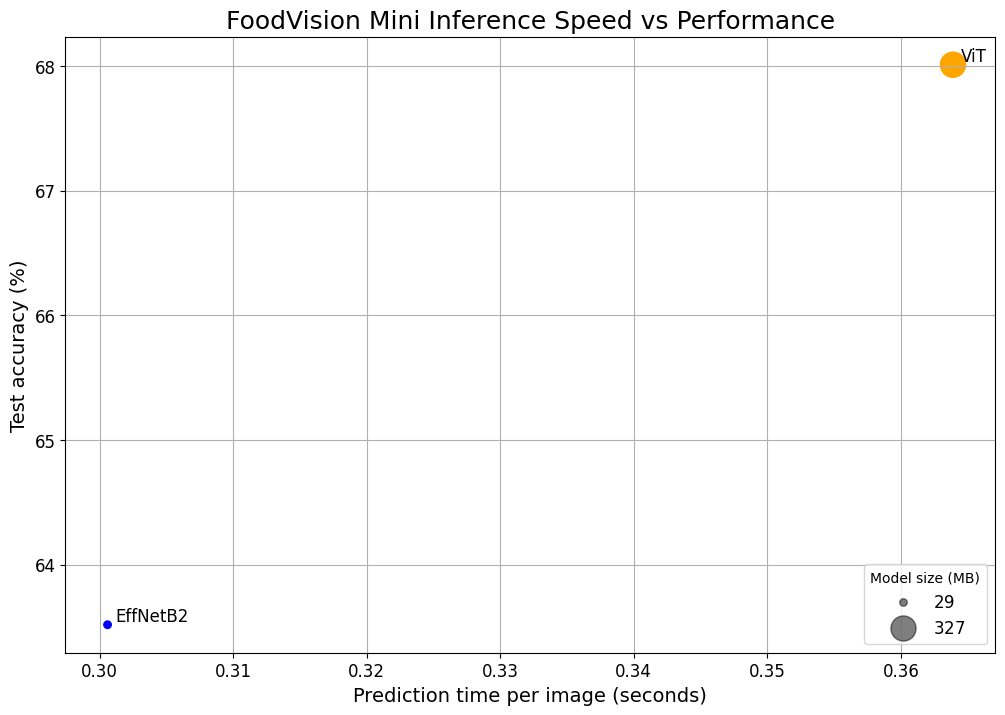

In [55]:
# 1. Create a plot from model comparison DataFrame
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df, 
                     x="time_per_pred_cpu", 
                     y="test_acc", 
                     c=["blue", "orange"], # what colours to use?
                     s="model_size (MB)") # size the dots by the model sizes

# 2. Add titles, labels and customize fontsize for aesthetics
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# 3. Annotate with model names
for index, row in df.iterrows():
    ax.annotate(text=row["model"], # note: depending on your version of Matplotlib, you may need to use "s=..." or "text=...", see: https://github.com/faustomorales/keras-ocr/issues/183#issuecomment-977733270 
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
                size=12)

# 4. Create a legend based on model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles, 
                              labels, 
                              loc="lower right", 
                              title="Model size (MB)",
                              fontsize=12)

# Show the figure
plt.show()

In [56]:
import gradio as gr
print(f"Gradio version: {gr.__version__}")

Gradio version: 4.31.4


In [57]:
# Put EffNetB2 on CPU
vit.to("cpu") 

# Check the device
next(iter(vit.parameters())).device

device(type='cpu')

In [58]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()
    
    # Transform the target image and add a batch dimension
    img = vit_transforms(img).unsqueeze(0)
    
    # Put model into evaluation mode and turn on inference mode
    vit.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(vit(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)
    
    # Return the prediction dictionary and prediction time 
    return pred_labels_and_probs, pred_time

In [59]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: data\organized\test\edible\Cantharellus californicus_46.jpg

Prediction label and probability dictionary: 
{'edible': 0.851386308670044, 'non-edible': 0.0909612774848938, 'toxic': 0.05765238776803017}
Prediction time: 0.38454 seconds


In [60]:
# Create a list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data\\organized\\test\\toxic\\Agaricus xanthodermus_57.jpg'],
 ['data\\organized\\test\\edible\\Retiboletus ornatipes_195.jpg'],
 ['data\\organized\\test\\edible\\Bolbitius titubans_120.jpg']]

In [61]:
import gradio as gr

# Create title, description and article strings
title = "🍄 Mushrooms Edibility Predictor 🍄"
description = "A ViT feature extractor computer vision model to classify images of mushrooms as edible, non-edible or toxic."
article = "Source code at [github](https://github.com/Rorjh/mushroom_image_classification)."

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list, 
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?

Running on local URL:  http://127.0.0.1:7860

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


In [64]:
import shutil
from pathlib import Path

# Create Mushrooms path
mushrooms_demo_path = Path("demos/mushrooms/")

# Remove files that might already exist there and create new directory
if mushrooms_demo_path.exists():
    shutil.rmtree(mushrooms_demo_path)
    mushrooms_demo_path.mkdir(parents=True, # make the parent folders?
                                    exist_ok=True) # create it even if it already exists?
else:
    # If the file doesn't exist, create it anyway
    mushrooms_demo_path.mkdir(parents=True, 
                                    exist_ok=True)

In [65]:
import shutil
from pathlib import Path

# 1. Create an examples directory
mushrooms_examples_path = mushrooms_demo_path / "examples"
mushrooms_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
mushrooms_examples = [Path('data/organized/test/edible/Agaricus augustus_330.jpg'),
                            Path('data/organized/test/non-edible/Coprinopsis lagopus_75.jpg'),
                            Path('data/organized/test/toxic/Amanita augusta_220.jpg')]

# 3. Copy the three random images to the examples directory
for example in mushrooms_examples:
    destination = mushrooms_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying data\organized\test\edible\Agaricus augustus_330.jpg to demos\mushrooms\examples\Agaricus augustus_330.jpg
[INFO] Copying data\organized\test\non-edible\Coprinopsis lagopus_75.jpg to demos\mushrooms\examples\Coprinopsis lagopus_75.jpg
[INFO] Copying data\organized\test\toxic\Amanita augusta_220.jpg to demos\mushrooms\examples\Amanita augusta_220.jpg


In [66]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(mushrooms_examples_path)]
example_list

[['examples/Agaricus augustus_330.jpg'],
 ['examples/Amanita augusta_220.jpg'],
 ['examples/Coprinopsis lagopus_75.jpg']]

In [68]:
import shutil

# Create a source path for our target model
vit_mushrooms_model_path = "models/pretrained_vit_feature_extractor.pth"

# Create a destination path for our target model 
vit_mushrooms_model_destination = mushrooms_demo_path / vit_mushrooms_model_path.split("/")[1]

# Try to move the file
try:
    print(f"[INFO] Attempting to move {vit_mushrooms_model_path} to {vit_mushrooms_model_destination}")
    
    # Move the model
    shutil.copy(src=vit_mushrooms_model_path, 
                dst=vit_mushrooms_model_destination)
    
    print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {vit_mushrooms_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {vit_mushrooms_model_destination}: {vit_mushrooms_model_destination.exists()}")

[INFO] Attempting to move models/pretrained_vit_feature_extractor.pth to demos\mushrooms\pretrained_vit_feature_extractor.pth
[INFO] Model move complete.


In [69]:
%%writefile demos/mushrooms/model.py
import torch
import torchvision

from torch import nn


def create_vit_model(num_classes:int=3, 
                          seed:int=42):
    """Creates a ViT feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): ViT feature extractor model. 
        transforms (torchvision.transforms): ViT image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)) # update to reflect target number of classes
    
    return model, transforms

Writing demos/mushrooms/model.py
